In [1]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy, categorical_crossentropy
from keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf

/Users/tradergllc/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from time import time
# from scipy.spatial.distance import euclidean
from sklearn.metrics import average_precision_score
from scipy.stats import multivariate_normal as multi_norm

### Load Data

In [4]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

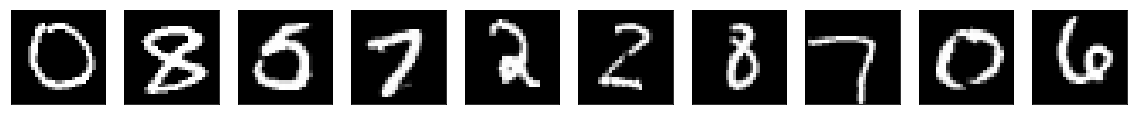

In [5]:
n = 10  # how many digits we will display
choice = np.random.choice(range(len(x_train)), n, replace=False)
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[choice[i]].squeeze())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Train VAE

In [6]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [7]:
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = 28

# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
filters = 16
latent_dim = 16
epochs = 30

In [8]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3136)         0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
dense_1 (D

In [9]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
# x = Dense(128, activation='relu')(latent_inputs)
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
_________________________________________________________________


In [10]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

In [11]:
reconstruction_loss = binary_crossentropy(K.flatten(inputs),K.flatten(outputs))
reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [12]:
def euclidean(x, y=0):
    dist = K.sqrt(K.sum(K.pow(x - y, 2), axis=1))
#     print K.int_shape(dist)
    return dist

In [13]:
def LR(x, y, mu, sigma, nu=0.1):
#     midpoint = 0.5 * (x + y)

#     # Assumes each dim has equal variance
#     m = euclidean(midpoint, mu)
#     d = euclidean(0.5* (x - y))

#     m_prime = tf.divide(m , sigma)
#     d_prime = tf.divide(d , sigma)
#     t = tf.divide(nu , sigma)

#     LR = 0.5*(K.pow(m_prime,2)+ K.pow(d_prime,2)*(2- K.pow(t,-2)))
    LR = euclidean(x, y)
    return LR

In [14]:
def LR_triplet_loss(x, mu, sigma, nu=0.1, margin=0.5):
    pos = LR(x[0], x[1], mu, sigma)
    neg = LR(x[0], x[2], mu, sigma)
    loss = K.sum(K.maximum(margin + pos - neg, 0))
#     print K.int_shape(loss)
    return loss

In [15]:
z_triplet = K.reshape(z, (3, batch_size, latent_dim))
mu, sigma = tf.nn.moments(z, axes=[0,1])
# print mu, sigma
vae.add_loss(0.1 * LR_triplet_loss(z_triplet, mu, sigma))

vae.compile(optimizer=Adam(lr=0.001, decay=1.0e-4))
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 16), (None, 16),  424480    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         108993    
Total params: 533,473
Trainable params: 533,473
Non-trainable params: 0
_________________________________________________________________


In [16]:
vae.losses

[<tf.Tensor 'Mean_1:0' shape=() dtype=float32>,
 <tf.Tensor 'mul_2:0' shape=() dtype=float32>]

In [17]:
def generator(x_train, y_train, batch_size=128):
    while True:
        where = [np.where(y_train == i)[0] for i in range(10)]
        
        batch = []
        for i in np.arange(batch_size):
            pos_cls, neg_cls = np.random.choice(range(10), 2, replace=False)
            anchor = np.random.choice(where[pos_cls], 1)
            pos = np.random.choice(where[pos_cls], 1)
            neg = np.random.choice(where[neg_cls], 1)
            batch.append([x_train[anchor], x_train[pos], x_train[neg]])
        
        batch = np.array(batch).reshape((-1, 3, image_size, image_size, 1))
        batch = batch.transpose((1, 0, 2, 3, 4)).reshape((-1, image_size, image_size, 1))
        yield (batch, None)

In [18]:
data_gen = generator(x_train, y_train, batch_size=batch_size)

In [19]:
batch = data_gen.next()

In [20]:
batch[0].shape

(384, 28, 28, 1)

In [21]:
batch = batch[0].reshape((3, batch_size, image_size, image_size, 1))
print batch.shape

(3, 128, 28, 28, 1)


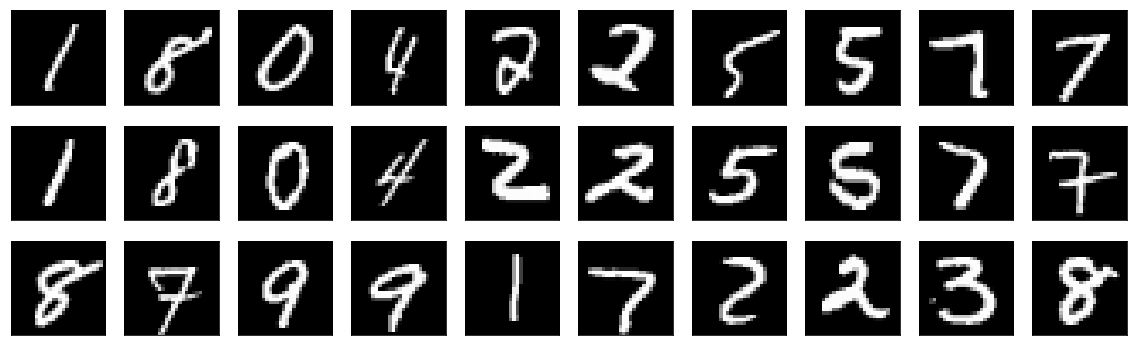

In [22]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(batch[0, i].squeeze())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(batch[1, i].squeeze())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(batch[2, i].squeeze())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [23]:
# train the autoencoder
vae.fit_generator(data_gen,epochs=epochs, steps_per_epoch=100)

Epoch 1/30
100/100 [==============================] - 67s 672ms/step - loss: 277.5393
Epoch 2/30
100/100 [==============================] - 71s 712ms/step - loss: 187.3041
Epoch 3/30
100/100 [==============================] - 61s 608ms/step - loss: 156.4464
Epoch 4/30
100/100 [==============================] - 61s 608ms/step - loss: 133.4839
Epoch 5/30
100/100 [==============================] - 61s 609ms/step - loss: 123.0488
Epoch 6/30
100/100 [==============================] - 61s 610ms/step - loss: 117.7176
Epoch 7/30
100/100 [==============================] - 61s 615ms/step - loss: 114.3142
Epoch 8/30
100/100 [==============================] - 64s 643ms/step - loss: 112.7365
Epoch 9/30
100/100 [==============================] - 64s 638ms/step - loss: 111.3122
Epoch 10/30
100/100 [==============================] - 63s 629ms/step - loss: 110.3076
Epoch 11/30
100/100 [==============================] - 63s 628ms/step - loss: 109.1139
Epoch 12/30
100/100 [==============================]

In [24]:
# np.save('encoder-mnist-triplet-LR.npy', encoder.get_weights())
# np.save('decoder-mnist-triplet-LR.npy', decoder.get_weights())

np.save('encoder-mnist-triplet-l2.npy', encoder.get_weights())
np.save('decoder-mnist-triplet-l2.npy', decoder.get_weights())

In [25]:
n = 10  # how many digits we will display
choice = np.random.choice(range(len(x_test)), n, replace=False)

encoded_imgs = encoder.predict(x_test[choice])
decoded_imgs = decoder.predict(encoded_imgs[2])

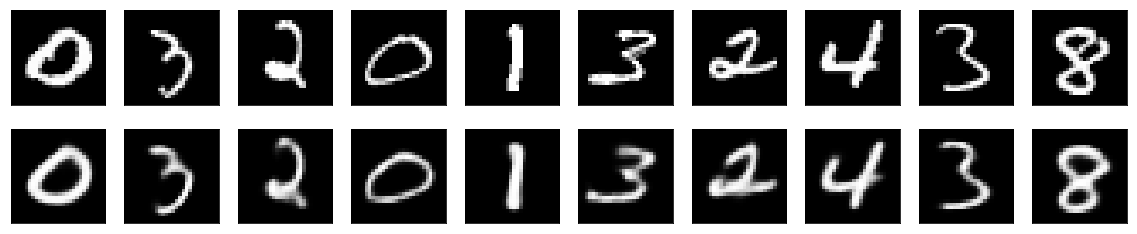

In [26]:
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[choice[i]].squeeze())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].squeeze())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [27]:
decoded_imgs.max()

0.9987494

In [28]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
x_test_encoded = np.array(x_test_encoded)

In [29]:
choice = np.random.choice(range(len(x_test)), 1000, replace=False)
x_tsne = x_test_encoded[2, choice]

In [30]:
x_tsne.shape

(1000, 16)

In [31]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
x_tsne = tsne.fit_transform(x_tsne)

In [32]:
x_tsne.shape

(1000, 2)

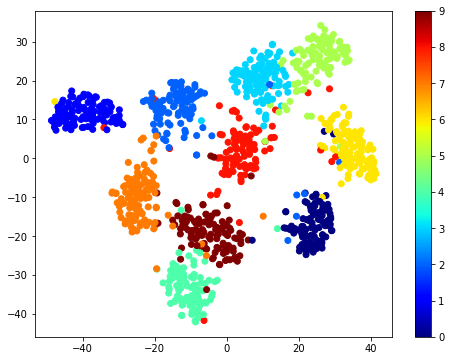

In [33]:
plt.figure(figsize=(8, 6))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_test[choice], cmap='jet')
plt.colorbar()
plt.show()

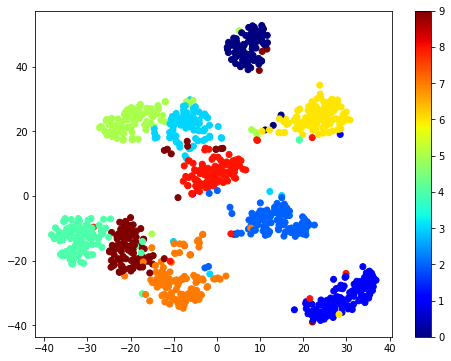

In [32]:
plt.figure(figsize=(8, 6))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_test[choice], cmap='jet')
plt.colorbar()
plt.show()

In [34]:
mean = np.mean(x_test_encoded[0], axis=0)
print mean

std = np.std(x_test_encoded[0], axis=0)
print std

[-0.00073965  0.00972675 -0.01467734  0.02635945 -0.0033467  -0.0650244
  0.07860744 -0.02962271 -0.0248027  -0.0128824  -0.06396278 -0.06631697
 -0.02364184  0.02004944 -0.08504366 -0.00961525]
[0.8846432  0.81281394 0.10349388 0.96260625 1.1548835  1.0709858
 0.88360226 1.0357819  0.9028774  0.8890288  1.0319145  1.0114918
 0.74268067 0.81740105 0.87446445 1.0224632 ]


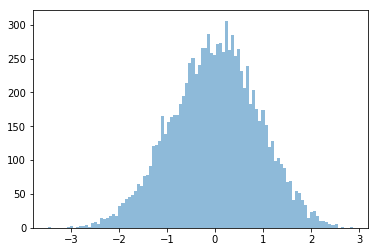

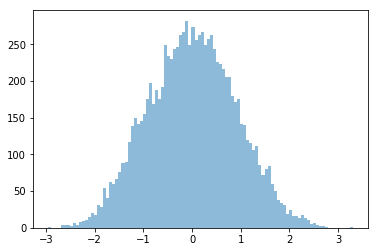

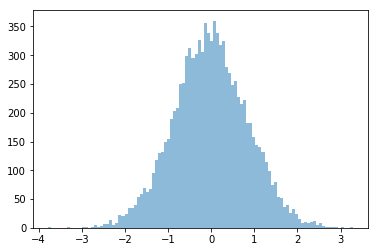

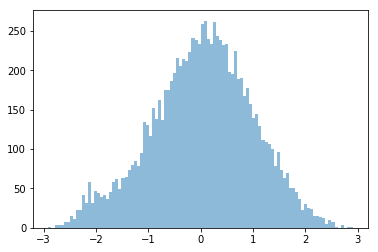

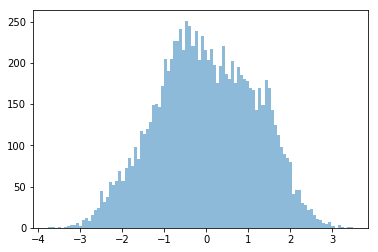

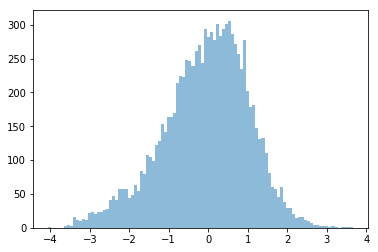

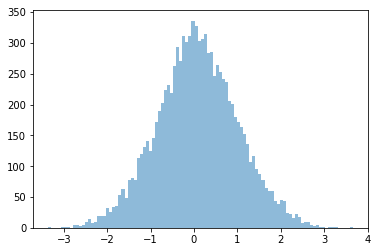

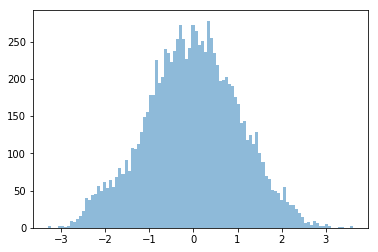

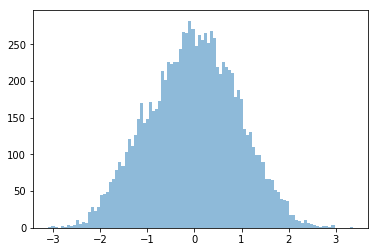

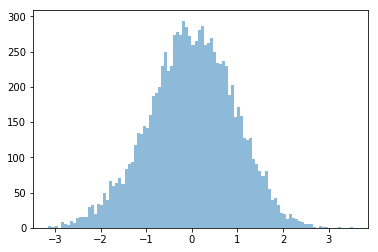

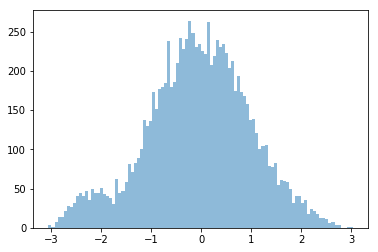

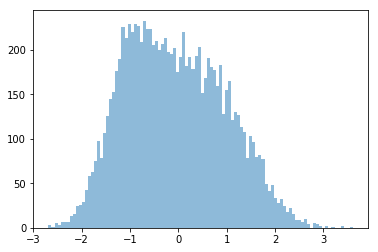

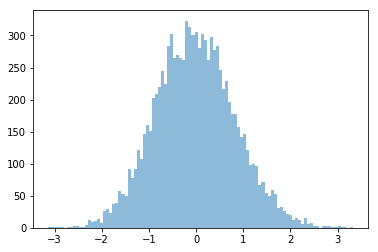

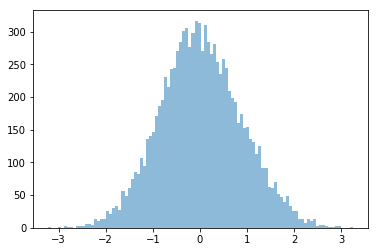

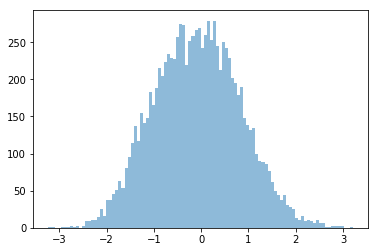

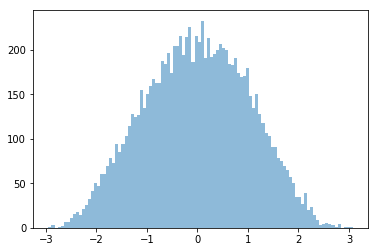

In [35]:
for i in range(len(std)):
    plt.hist(x_test_encoded[2, :, i], bins=100, alpha=0.5)
    plt.show()

In [63]:
def l2(x, y=0, axis=0):
    return np.sqrt(np.sum(np.power(x - y, 2), axis=axis))

In [137]:
from scipy.spatial import distance

p_choice = np.random.choice(range(x_test.shape[0]), 1000, replace=False)
points = encoder.predict(x_test[p_choice])[2]
print points.shape

(1000, 16)


In [143]:
dist_matrix = np.zeros((points.shape[0], points.shape[0]))

test_mean = points.mean(axis=0)
print test_mean
sigma = np.std(points)
print sigma
nu = 0.1

for i in np.arange(points.shape[0]):
    midpoint = 0.5 * (points[i] + points[i+1:])

    # Assumes each dim has equal variance
    m = l2(midpoint, test_mean, axis=1)
    d = l2(0.5* (points[i] - points[i+1:]), axis=1)

    m_prime = (m / sigma).astype(np.float64)
    d_prime = (d / sigma).astype(np.float64)
    t = (nu / sigma).astype(np.float64)
        
    LR = np.power(0.5/t, latent_dim)* np.exp(0.5*(np.power(m_prime,2)+ \
                        np.power(d_prime,2)*(2- np.power(t,-2))))
    dist_matrix[i, i+1:] = LR #l2(points[i], points[i+1:], axis=1)

[ 0.02078314 -0.01315155 -0.00953159 -0.02325385 -0.01920935 -0.05585504
  0.10350611 -0.02339762 -0.0567167  -0.02740696 -0.10332695 -0.0143494
 -0.05221109  0.02782646 -0.06127024  0.03229897]
0.96934927


In [144]:
dist_matrix = dist_matrix + dist_matrix.transpose()
print dist_matrix.max()

2031309256.607455


In [145]:
adj_matrix = np.zeros((points.shape[0], points.shape[0]))
labels = y_test[p_choice]
for i in np.arange(points.shape[0]):
    adj_matrix[i, np.where(labels == labels[i])[0]] = 1
print adj_matrix

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [146]:
adj_matrix = adj_matrix - np.diag(np.ones((adj_matrix.shape[0])))
print adj_matrix

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [147]:
rank = [1,5]

for r in rank:
    hit = 0
    tot = 0.0
    
    for i in np.arange(adj_matrix.shape[0]):
        idx = np.argsort(dist_matrix[i])[::-1]
        if 1 in adj_matrix[i, idx][:r]:
            hit += 1
        tot += 1
    
    print 'rank %d: %f' % (r, hit / tot)

rank 1: 0.922000
rank 5: 0.988000


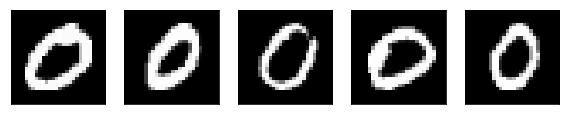

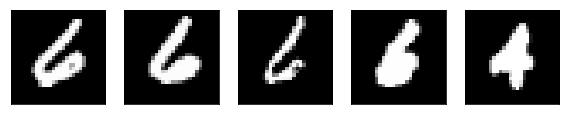

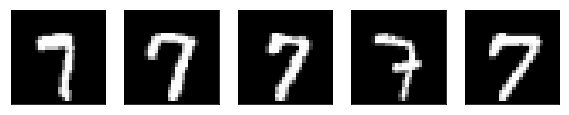

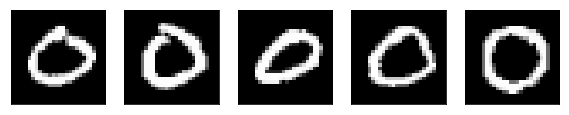

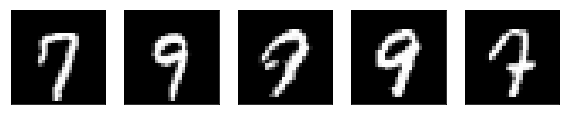

rank 5: 1.000000


In [51]:
rank = [5]

for r in rank:
    hit = 0
    tot = 0.0
    
    for i in np.arange(5):
        idx = np.argsort(dist_matrix[i])
        
        plt.figure(figsize=(20, 2))
        for j in range(r):
            # display original
            ax = plt.subplot(1, n, j + 1)
            plt.imshow(x_test[p_choice][idx][1:r+1][j].squeeze())
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()
            
        if 1 in adj_matrix[i, idx][1:r+1]:
            hit += 1
        tot += 1
    
    print 'rank %d: %f' % (r, hit / tot)